# SIR Models with Time-Dependent Leaky Vaccination and Immunity Loss

These models include the loss of immunity over time. The first model limits immunity loss to vaccination only, i.e., it assumes that immunity from infection is lifelong. The second model allows immunity acquired through vaccination and infection both to wane over time. 

Immunity loss over time is implemented by creating many compartments $v_{1, 2, ..., n}$ such that if $i < j$ then $v_i$ offers less protection from illness (i.e. has a lower VE) than $v_j$. When people get vaccinated, they move into the category $v_n$, where $n \geq i$ for any $i$.

**New Variables Introduced:** <br/>
* $\alpha$: The rate at which immunity through vaccination declines.
* $v_n$: This category denotes newly vaccinated individuals. It is the highest level of vaccine protection.
* $v_i$: These categories denote declined levels of immunity through vaccination. Note that $i < n$ for any $i$.

**Assumptions** <br/>
* All models assume that individuals move through the $v_i$ categories at the same rate.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def update(t, delta_t, current_val, f_prime):
    return current_val + (delta_t * f_prime)

In [3]:
def su_dot(p, C, D_w, D_su, i):
    return -p * (D_su @ C @ D_w) @ i

def sw_dot(p, C, D_w, D_sw, i, theta):
    vaccinated_s = D_sw @ theta
    infected_s = p * (D_sw @ C @ D_w) @ i
    return -vaccinated_s - infected_s

def v1_dot(VE, p, C, D_w, D_vn, D_v1, i, alpha):
    waned_v = D_vn @ alpha
    infected_v = ((1 - VE) * p) * (D_v1 @ C @ D_w) @ i
    return waned_v - infected_v

def i_dot(p, C, D_w, D_su, D_sw, D_vn, D_v1, gamma, i, VEs):
    infected_su = p * (D_su @ C @ D_w) @ i
    infected_sw = p * (D_sw @ C @ D_w) @ i
    infected_vn = ((1 - VEs[0]) * p) * (D_vn @ C @ D_w) @ i
    infected_v1 = ((1 - VEs[1]) * p) * (D_v1 @ C @ D_w) @ i
    recovered_i = gamma * i
    return infected_su + infected_sw + infected_vn + infected_v1 - recovered_i

In [4]:
#set up initial conditions
N = 100000
VEs = [0.8, 0.5]
gamma = 1/14
beta = 1/4
phis = [1/8, 1/6]

t_init = 0
delta_t = 0.125

i_0 = 1 / N
vn_0 = 0 #assume no one is vaccinated at beginning
v1_0 = 0
s0 = 1 - i_0
r_0 = 0

num_groups = 2
p = 0.6
proportions = [0.65, 0.35]
max_t = 125

#create arrays and vectors
C = np.array([[0.8, 0.2],[0.5, 0.5]])
omegas = np.array(proportions)
theta = np.array([1/4, 1/6]).reshape((num_groups, 1))
alpha  = np.array([1/30 for _ in range(num_groups)]).reshape((num_groups, 1))

#compute proportion of susceptible, infected, etc for each group
su_init = np.array([phi * s0 for phi in phis]).reshape((num_groups, 1))
sw_init = np.array([(1 - phi) * s0 for phi in phis]).reshape((num_groups, 1))
vn_init = np.array([vn_0 for _ in range(num_groups)]).reshape((num_groups, 1))
v1_init = np.array([v1_0 for _ in range(num_groups)]).reshape((num_groups, 1))
i_init = np.array([i_0 for _ in range(num_groups)]).reshape((num_groups, 1))
r_init = np.array([r_0 for _ in range(num_groups)]).reshape((num_groups, 1))

## Immunity Loss through Vaccination Only

The first model assumes that immunity from infection is lifelong, while immunity from vaccination can wane over time. 

In [5]:
def vn_dot(VE, p, C, D_w, D_vn, D_sw, i, theta, alpha):
    vaccinated_s = D_sw @ theta
    infected_v = ((1 - VE) * p) * (D_vn @ C @ D_w) @ i
    waned_v = D_vn @ alpha
    return vaccinated_s - infected_v - waned_v


def r_dot(gamma, i):
    return gamma * i

In [6]:
def solve(su_init, sw_init, vn_init, v1_init, i_init, r_init, p, C, omegas, delta_t, max_time, gamma, VEs, theta, alpha):
    #set up omega matrix
    #NB this is really D_w^{-1} but for simplicity in variable names it's called D_w
    D_w = np.diag([1 / w for w in omegas])

    #record keeping
    su = [su_init]
    sw = [sw_init]
    vn = [vn_init]
    v1 = [v1_init]
    i = [i_init]
    r = [r_init]
    t = [0]

    #solve loop
    idx = 0
    while t[idx] < max_time:
        #update D_s and D_v at each timestep
        D_su = np.diag(su[idx].flatten())
        D_sw= np.diag(sw[idx].flatten())
        D_vn = np.diag(vn[idx].flatten())
        D_v1 = np.diag(v1[idx].flatten())
        
        #set up derivatives
        su_update = su_dot(p, C, D_w, D_su, i[idx])
        sw_update = sw_dot(p, C, D_w, D_sw, i[idx], theta)
        vn_update = vn_dot(VEs[0], p, C, D_w, D_vn, D_sw, i[idx], theta, alpha)
        v1_update = v1_dot(VEs[1], p, C, D_w, D_vn, D_v1, i[idx], alpha)
        i_update = i_dot(p, C, D_w, D_su, D_sw, D_vn, D_v1, gamma, i[idx], VEs)
        r_update = r_dot(gamma, i[idx])

        #update variables
        su.append(update(t[idx], delta_t, su[idx], su_update))
        sw.append(update(t[idx], delta_t, sw[idx], sw_update))
        vn.append(update(t[idx], delta_t, vn[idx], vn_update))
        v1.append(update(t[idx], delta_t, v1[idx], v1_update))
        i.append(update(t[idx], delta_t, i[idx], i_update))
        r.append(update(t[idx], delta_t, r[idx], r_update))

        #update time
        t.append(t[idx] + delta_t)
        idx += 1

    return su, sw, vn, v1, i, r, t

In [7]:
#solve
su, sw, vn, v1, i, r, t = solve(su_init, sw_init, vn_init, v1_init, i_init, r_init, p, C, omegas, delta_t, max_t, gamma, VEs, theta, alpha)

#rework results so the final arrays have the two groups as the rows and their values over time as columns
all_su = np.concatenate(su, axis=1)
all_sw = np.concatenate(sw, axis=1)
all_vn = np.concatenate(vn, axis=1)
all_v1 = np.concatenate(v1, axis=1)
all_i = np.concatenate(i, axis=1)
all_r = np.concatenate(r, axis=1)

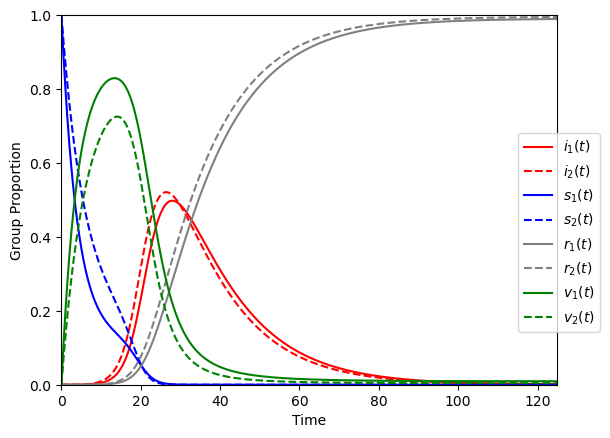

In [8]:
all_s = all_su + all_sw
all_v = all_vn + all_v1
plt.plot(t, all_i[0, :], color='red', label=r'$i_1(t)$')
plt.plot(t, all_i[1, :], color='red', linestyle='dashed', label=r'$i_2(t)$')
plt.plot(t, all_s[0, :], color='blue', label=r'$s_1(t)$')
plt.plot(t, all_s[1, :], color='blue', linestyle='dashed', label=r'$s_2(t)$')
plt.plot(t, all_r[0, :], color='gray', label=r'$r_1(t)$')
plt.plot(t, all_r[1, :], color='gray', linestyle='dashed', label=r'$r_2(t)$')
plt.plot(t, all_v[0, :], color='green', label=r'$v_1(t)$')
plt.plot(t, all_v[1, :], color='green', linestyle='dashed', label=r'$v_2(t)$')

plt.legend(bbox_to_anchor=(1.1, 0.7))

plt.xlim([t[0], t[-1]])
plt.ylim([0, 1])

plt.xlabel('Time')
plt.ylabel('Group Proportion')

plt.show()

## Immunity Loss through Vaccination and Infections

This model allows individuals to lose immunity that they have gained from infection. This is implemented by creating a new transition function from $r$ to $v_n$.

**New Variables Introduced:** <br/>
* $\psi$: The rate at which a person becomes susceptible to infection after vaccination.
* $r$: While not a new variable, $r$ has been re-factored to allow individuals to regain susceptibility to infection over time.
* $v_n$: Along with representing the freshly-vaccinated proportion of the population, $v_n$ now also represents those who have been immunized through infection.

**Assumptions** <br/>
* We assume that every group leaves the $r$ category at the same rate, i.e. $\psi$ remains constant among different population groups.

In [9]:
def vn_dot(VE, p, C, D_w, D_vn, D_sw, i, r, theta, alpha, psi):
    immunized_r = psi * r
    vaccinated_s = D_sw @ theta
    infected_v = ((1 - VE) * p) * (D_vn @ C @ D_w) @ i
    waned_v = D_vn @ alpha
    return vaccinated_s + immunized_r - infected_v - waned_v

def r_dot(gamma, i, r, psi):
    return (gamma * i) - (psi * r)

In [10]:
def solve(su_init, sw_init, vn_init, v1_init, i_init, r_init, p, C, omegas, delta_t, max_time, gamma, VEs, theta, alpha, psi):
    #set up omega matrix
    #NB this is really D_w^{-1} but for simplicity in variable names it's called D_w
    D_w = np.diag([1 / w for w in omegas])

    #record keeping
    su = [su_init]
    sw = [sw_init]
    vn = [vn_init]
    v1 = [v1_init]
    i = [i_init]
    r = [r_init]
    t = [0]

    #solve loop
    idx = 0
    while t[idx] < max_time:
        #update D_s and D_v at each timestep
        D_su = np.diag(su[idx].flatten())
        D_sw= np.diag(sw[idx].flatten())
        D_vn = np.diag(vn[idx].flatten())
        D_v1 = np.diag(v1[idx].flatten())
        
        #set up derivatives
        su_update = su_dot(p, C, D_w, D_su, i[idx])
        sw_update = sw_dot(p, C, D_w, D_sw, i[idx], theta)
        vn_update = vn_dot(VEs[0], p, C, D_w, D_vn, D_sw, i[idx], r[idx], theta, alpha, psi)
        v1_update = v1_dot(VEs[1], p, C, D_w, D_vn, D_v1, i[idx], alpha)
        i_update = i_dot(p, C, D_w, D_su, D_sw, D_vn, D_v1, gamma, i[idx], VEs)
        r_update = r_dot(gamma, i[idx], r[idx], psi)

        #update variables
        su.append(update(t[idx], delta_t, su[idx], su_update))
        sw.append(update(t[idx], delta_t, sw[idx], sw_update))
        vn.append(update(t[idx], delta_t, vn[idx], vn_update))
        v1.append(update(t[idx], delta_t, v1[idx], v1_update))
        i.append(update(t[idx], delta_t, i[idx], i_update))
        r.append(update(t[idx], delta_t, r[idx], r_update))

        #update time
        t.append(t[idx] + delta_t)
        idx += 1

    return su, sw, vn, v1, i, r, t

In [11]:
#set up psi
psi = 1/10

#solve
su, sw, vn, v1, i, r, t = solve(su_init, sw_init, vn_init, v1_init, i_init, r_init, p, 
                                C, omegas, delta_t, max_t, gamma, VEs, theta, alpha, psi)

#rework results so the final arrays have the two groups as the rows and their values over time as columns
all_su = np.concatenate(su, axis=1)
all_sw = np.concatenate(sw, axis=1)
all_vn = np.concatenate(vn, axis=1)
all_v1 = np.concatenate(v1, axis=1)
all_i = np.concatenate(i, axis=1)
all_r = np.concatenate(r, axis=1)

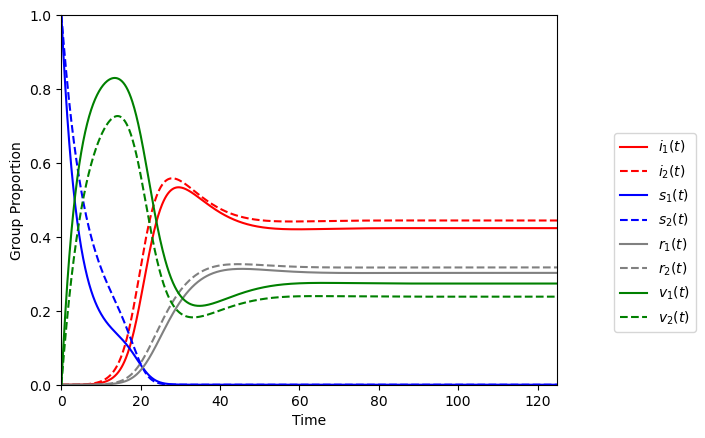

In [12]:
all_s = all_su + all_sw
all_v = all_vn + all_v1
plt.plot(t, all_i[0, :], color='red', label=r'$i_1(t)$')
plt.plot(t, all_i[1, :], color='red', linestyle='dashed', label=r'$i_2(t)$')
plt.plot(t, all_s[0, :], color='blue', label=r'$s_1(t)$')
plt.plot(t, all_s[1, :], color='blue', linestyle='dashed', label=r'$s_2(t)$')
plt.plot(t, all_r[0, :], color='gray', label=r'$r_1(t)$')
plt.plot(t, all_r[1, :], color='gray', linestyle='dashed', label=r'$r_2(t)$')
plt.plot(t, all_v[0, :], color='green', label=r'$v_1(t)$')
plt.plot(t, all_v[1, :], color='green', linestyle='dashed', label=r'$v_2(t)$')

plt.legend(bbox_to_anchor=(1.1, 0.7))

plt.xlim([t[0], t[-1]])
plt.ylim([0, 1])

plt.xlabel('Time')
plt.ylabel('Group Proportion')

plt.show()